To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/dsclass2022/blob/main/Module_4_Trees/Module%204%20Recursive%20Partitioning.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'

<span style="font-family: Palatino; font-size: 40px; color: purple">
             Recursive Partitionin and Tree Models
</span>


Spring 2022 - Instructors: Roger Stein and Ben Wolfson -
***

In [55]:
#If opening in colab run this cell
#!git clone https://github.com/bwolfson2/foster_2021
#%cd foster_2021/Module2_Supervised/

In [56]:
from IPython.core.display import HTML

HTML("""

    <STYLE type="text/css">
       H1 {font-family: Palatino; font-size: 30px; color: purple}
    </STYLE>

""")

# Set-up and housekeeping

## Some general imports

In [30]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Define some helper functions that we will use later

### Performance measure utilities

#### Entropy and IG

In [31]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()  
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot 

#### Accuracy

In [32]:
def cm2accuracy(tab):                    # convert 2x2 confusion matrix to accuracy (pct correct)
    correct  = (tab[0][0] + tab[1][1])
    total    = sum(sum(tab))
    accuracy = correct/total
    return(accuracy)

### Visualization

In [33]:
def bool2txt(x,text):
    if x==0 : 
        return text[0]
    else: 
        return text[1]

In [34]:
import copy as c
def Decision_Surface(data, col1, col2, target, orig_model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()

    # ipdb.set_trace()  # insert this line into any Python code for debugging.  'n' in the dialog box moves to the next line of code
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    # make a copy of the model so we don't corrupt the original
    model = c.deepcopy(orig_model)
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)  
        
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")    
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot    
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="target", frameon=True)
    plt.show() 
    

In [35]:
def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

# Doing some more data science: Revisiting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [57]:
# Load Data
path="./data/"
fn = "titanic.csv"
full_path= path+fn
df = pd.read_csv(full_path)[["name", "survived", "pclass", "sex", "age", "fare","home_dest"]].dropna()
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")

# Drop outliers. This is to help the visualization in the next examples.
# --> In general, identifying and determining whether / how to deal with outliers is non-trival
df = df[df.fare < 400]

categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

df.head()

,name,survived,pclass,age,fare,home_dest,female
0,"Allen, Miss. Elisabeth Walton",1,1,29.0000,211.3375,"St Louis, MO",1
1,"Allison, Master. Hudson Trevor",1,1,0.9167,151.5500,"Montreal, PQ / Chesterville, ON",0
2,"Allison, Miss. Helen Loraine",0,1,2.0000,151.5500,"Montreal, PQ / Chesterville, ON",1
3,"Allison, Mr. Hudson Joshua Creighton",0,1,30.0000,151.5500,"Montreal, PQ / Chesterville, ON",0
4,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",0,1,25.0000,151.5500,"Montreal, PQ / Chesterville, ON",1


## The Classifier Tree: Recursive Splitting

Another way to predict the outcomomes for Titanic passengers is to use recursive partitioning (RP) algorithms.   


## Formalizing some of the intuition from EDA

***


**Entropy** ($H$) and **information gain** ($IG$) are useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="https://github.com/bwolfson2/foster_2020/blob/master/Module2_Supervised/images/dsfb_0304.png?raw=1" height=80% width=80%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
<td style="border: 0px; width: 30px"></td>
<td style="border: 0px"><img src="https://github.com/bwolfson2/foster_2020/blob/master/Module2_Supervised/images/dsfb_0305.png?raw=1" height=75% width=75%>
Figure 3-5. A classification tree split on the three-values Residence attribute.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

### Getting started with entropy and information gain

At the top of the notebook we defined Python functions for calculating these information theoretic measures of homogeneity (the *entropy*, $H$, and the *information gain*, $IG$).

We can now use these to test our prior hunch, that using 50 as a split on a passenger's `fare` allows us to predict whether someone will survive.  

In [58]:
threshold = 50
prior_entropy = entropy(df["survived"])
IG = information_gain(df, "fare", "survived", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0405 using a threshold of 50.00 given a prior entropy of 0.9969


But is `50` the *best* choice possible for a splitting critierion?  

We can answer that question definitively, with the helpf of a few lines of code, by applying brute-force search and simply testing *every* possible split for `fare`.

In [59]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

In [60]:
maximum_threshold, maximum_ig = best_threshold(df, "fare", "survived")

print ("The maximum IG we can achieve splitting on `fare` is %.4f using a split threshold of %.2f" % (maximum_ig, maximum_threshold))

The maximum IG we can achieve splitting on `fare` is 0.0572 using a split threshold of 15.50


In the same way that we automated the search for the best threshold, we can write a function to search through *every* variable of interest and find it's best splitting threshold.  From the results of that search, we can identify the variable whose best splitting threshold produces the most informaiton gain!

Now that we have a way of calculating $H$ and $IG$, let's test our prior hunch, that using 50 as a split on fare allows us to determine if someone will survive.

How good was our guess of 50? Let's use a function to loop through all possible splits on fare and see what is the best!

In [61]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0


    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh
            
    return (maximum_threshold, maximum_ig)

In [62]:
maximum_threshold, maximum_ig = best_threshold(df, "fare", "survived")

print ("the maximum IG we can achieve splitting on `fare` is %.4f using a split threshold of %.2f" % (maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on `fare` is 0.0572 using a split threshold of 15.50


## Finding the *best* split across *all* predictors

During our EDA, we noticed, that a split of about `50` on `fare` seemed to provide good discrimination between passenger outcomes.  It turned out that we were pretty close.

But how do we know that the best split on `fare` is the best split possible for the data set?  There could be other variables that provide even more information, if we split them properly.

We can answer this question in the same way we answered the previous one.  Another short routine can apply brute force to searching across *all* predictors and finding the best split on each and then selecting the one that provides the most information.

In [63]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""
    
    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)
        
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

In [64]:
max_col, max_threshold, max_ig = best_split(df, predictor_cols, "survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is female giving us a IG of 0.2813 using a thresh of 0.00


Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively, building a tree-structured model that may give better results. This recursive splitting is the basis for a "decision tree classifier" or "classifier tree", a popular and powerful class of machine learning algorithm. In particular, this specific algorithm is known as ID3 for Iterative Dichotomizer. 

What are some other ways you might consider splitting the data?

## Scaling up the splitting using `sklearn`

Rather than build a classifier tree from scratch (you could now do this!) let's use the implementation in `sklearn` implementation which includes some additional functionality. 

In [65]:
from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!! 
# Let's tell the model what is the data
decision_tree.fit(df[predictor_cols], df[target_col])

DecisionTreeClassifier(criterion='entropy', max_depth=3)

We now have a classifier tree, let's visualize the results!

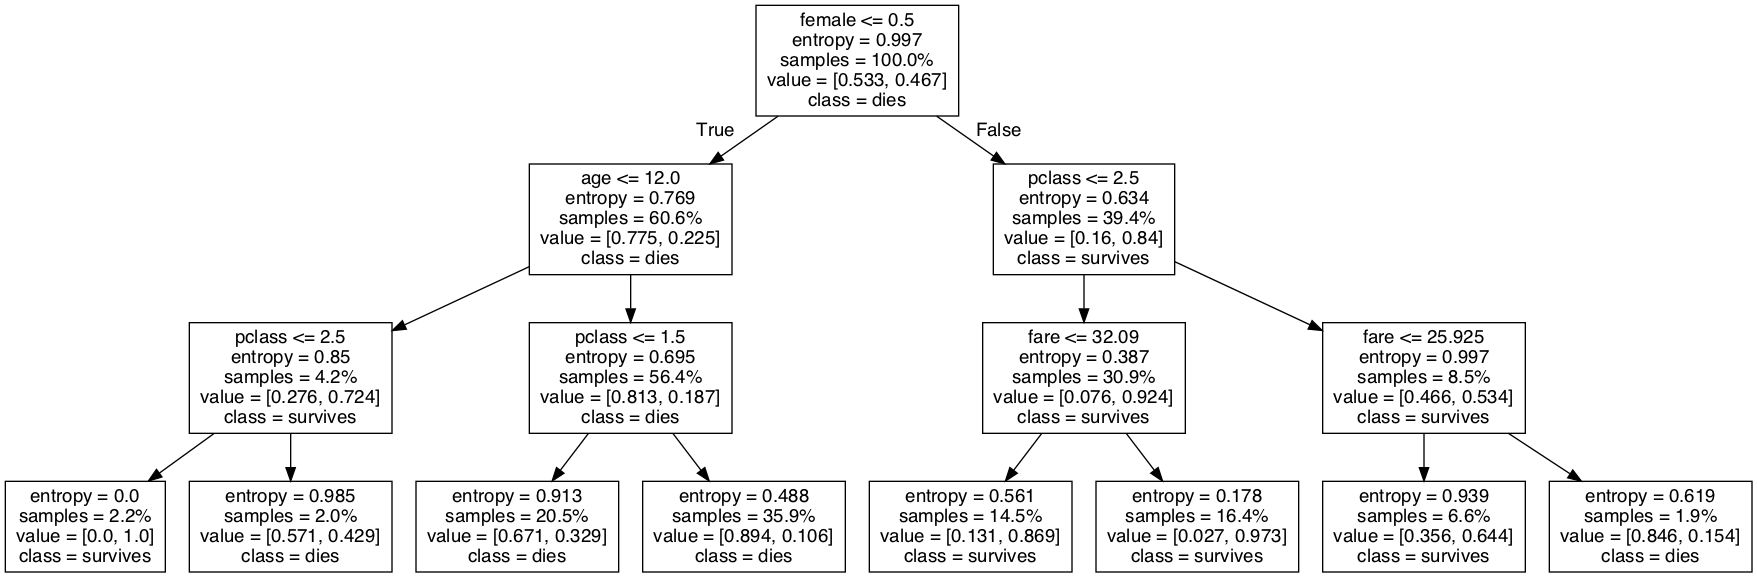

In [66]:
from IPython.display import Image
from sklearn.tree import export_graphviz

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])

### Evaluating the results (a little more...)

Let's look at `"age"` and `"fare"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

/Users/rogermstein/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


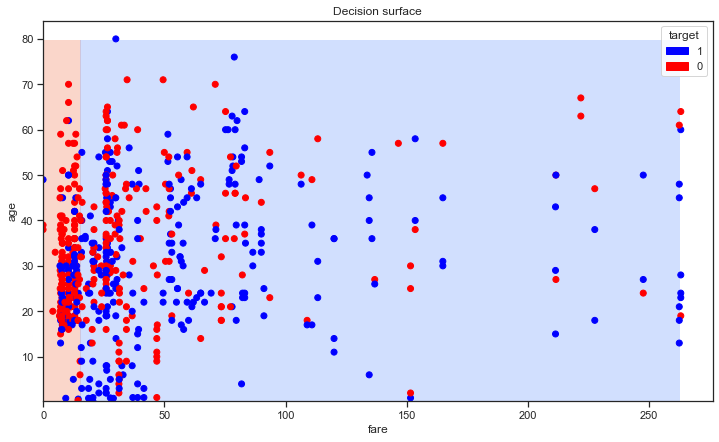

In [67]:
tree_depth=1

model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
Decision_Surface(df, "fare", "age", df.survived, model)

In [68]:
df.iloc[:,[2,3]].head()

,pclass,age
0,1,29.0000
1,1,0.9167
2,1,2.0000
3,1,30.0000
4,1,25.0000


How good is our model? Let's compute accuracy, the percent of times where we correctly identified whether a passenger survives.

In [69]:
from sklearn import metrics
print ( "Accuracy = %.2f" % (metrics.accuracy_score(decision_tree.predict(df[predictor_cols]), df["survived"])) )

Accuracy = 0.84


## Analyzing Fit

While accuracy is a good way to analyze fit, we run into a fundamental problem with decision trees. Theoretically, we could fit a model to every one of the data points. This tree model would have 100% accuracy on our data. 

Q: *So what should we do?*

A: Split the data into a training set and a test set. Check the accuracy of the model on the test set.

In [70]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.datasets import make_classification

In [71]:
data = make_classification(1000,n_features = 10,n_informative=2,class_sep=.01)
data_df = pd.DataFrame(data[0])
target_col = "class"
data_df[target_col] = data[1]
data_df.head()
predictor_cols = [i for i in data_df.columns if i != target_col]
predictor_cols, target_col


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'class')

In [72]:
df_train,df_test = train_test_split(data_df, test_size = .2)

In [73]:
df_train.shape,df_test.shape, df_train.columns

((800, 11),
 (200, 11),
 Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'class'], dtype='object'))

In [74]:
tree_depth = 1000
model = DecisionTreeClassifier(max_depth=tree_depth, 
                            criterion="entropy",
                            min_samples_leaf=1,
                              )
model.fit(df_train[predictor_cols],df_train[target_col])
print ( "Training Accuracy = %.2f" % (metrics.accuracy_score(model.predict(df_train[predictor_cols]), 
                                                             df_train[target_col])) )
print ( "Test Accuracy = %.2f" % (metrics.accuracy_score(model.predict(df_test[predictor_cols]),
                                                         df_test[target_col])) )

Training Accuracy = 1.00
Test Accuracy = 0.66


In [75]:
tree_depth=7
model = DecisionTreeClassifier(max_depth=tree_depth, 
                            criterion="entropy",
                            min_samples_leaf=1,
                              )
model.fit(df_train[predictor_cols],df_train[target_col])
print ( "Training Accuracy = %.2f" % (metrics.accuracy_score(model.predict(df_train[predictor_cols]), 
                                                             df_train[target_col])) )
print ( "Test Accuracy = %.2f" % (metrics.accuracy_score(model.predict(df_test[predictor_cols]),
                                                         df_test[target_col])) )

Training Accuracy = 0.81
Test Accuracy = 0.66


But, as we learned in Lecture 3, we can do a lot better for performance evaluation than using the `accuracy_score`...

## A better measure of classifier performance

In [77]:
from sklearn.model_selection import cross_val_score

X = df_test[predictor_cols]
Y = df_test[target_col]
auc = np.mean(cross_val_score(model, X, Y, scoring="roc_auc", cv=5))

print(f"AUC (test data) = {str(round(auc, 2))}")




AUC (test data) = 0.6
